In [1]:
import ROOT
import os
import json
import datetime
import numpy as np
import uproot
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.style.use('science')
plt.rcParams.update({
    "text.usetex": True
})


Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-l0brhr8c because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def get_uproot_trees(PROJECT_NAME,MLmethod,parentDirectory,prefix,binname,ML=False):
    basename_data="nSidis_"
    for b in binname.split("_")[::3]:
        basename_data+=b+"_"
    basename_data+="binned.root"
    basename_MC = basename_data.replace("nSidis","MC")
    if(ML==False):
        text="_noML"
    else:
        text=""
    fsweight = uproot.open("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{}/{}/postprocess_binned/{}/bru_obs/{}_{}{}/DataInWeightedTree0.root".format(PROJECT_NAME,MLmethod,parentDirectory,prefix,binname,text))
    fdata    = uproot.open("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{}/{}/postprocess_binned/{}/{}".format(PROJECT_NAME,MLmethod,parentDirectory,basename_data))
    fmc      = uproot.open("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{}/{}/postprocess_binned/{}/{}".format(PROJECT_NAME,MLmethod,parentDirectory,basename_MC))
    tsweight = fsweight[binname]
    tdata    = fdata[binname]
    tmc      = fmc[binname]
    
    return tsweight,tdata,tmc

In [11]:
def get_signal_background(tsweight,tdata,tmc,branchName,N,ML):
    #N = tdata.num_entries
    sig_sweight  = tsweight["Signal"].array(library="np",entry_stop=N)
    truePi0_mc   = tmc["truePi0"].array(library="np",entry_stop=N)
    bkg_sweight  = tsweight["BG"].array(library="np",entry_stop=N)
    run_mc       = tmc["run"].array(library="np",entry_stop=N)
    run_data       = tdata["run"].array(library="np",entry_stop=N)
    pionpid_mc   = tmc["truepid_pion"].array(library="np",entry_stop=N)
    pg1_mc       = tmc["prob_g1"].array(library="np",entry_stop=N)
    pg2_mc       = tmc["prob_g2"].array(library="np",entry_stop=N)
    isGood_mc    = tmc["isGoodEventWithoutML"].array(library="np",entry_stop=N)
    
    x_data = tdata[branchName].array(library="np",entry_stop=N)
    x_mc   = tmc[branchName].array(library="np",entry_stop=N)
    
    goodEv = np.array(sig_sweight!=0)*np.array(run_data<=5332)
    
    data = [x_data[goodEv],[sig_sweight[goodEv],bkg_sweight[goodEv]]]
    if(ML==True):
        mc   = [x_mc[(truePi0_mc==True) & (run_mc==-11) & (pg1_mc>0.9) & (pg2_mc>0.9)],x_mc[(truePi0_mc==False) & (run_mc==-11)& (pg1_mc>0.9) & (pg2_mc>0.9)]]
    else:
        mc   = [x_mc[(truePi0_mc==True) & (run_mc==-11) & (isGood_mc==1)],x_mc[(truePi0_mc==False) & (run_mc==-11)&(isGood_mc==1)]]
    return data,mc

In [12]:
def get_plot_x_y(data=[],weights=[],MIN=0,MAX=1):
    nbins=100
    if(weights==[]):
        weights=np.ones(len(data))
    n,bins,patches=plt.hist(data,bins=nbins,weights=weights,density=True,range=(MIN,MAX))
    plt.close()
    X = bins[:-1]+ 0.5*(bins[1:] - bins[:-1])
    Y = n
    return X,Y

In [16]:
def create_plot(tsweight,tdata,tmc,branchName,xlabel,N,binname,which,ML=False):
    data , mc    = get_signal_background(tsweight,tdata,tmc,branchName,N,ML)

    MIN,MAX=0.2,1.2
    if(branchName=="Mh"):
        MIN,MAX=0.27,1.8
    elif(branchName=="x"):
        MIN,MAX=0,0.8
    elif(branchName=="Mgg"):
        MIN,MAX=0.1,0.2
    elif(branchName=="phi_h" or branchName=="phi_R0"):
        MIN,MAX=-3.1415,3.1415
    scatter_data_sig = get_plot_x_y(data[0],data[1][0],MIN,MAX)
    scatter_data_bkg = get_plot_x_y(data[0],data[1][1],MIN,MAX)
    scatter_mc_sig   = get_plot_x_y(mc[0],[],MIN,MAX)
    scatter_mc_bkg   = get_plot_x_y(mc[1],[],MIN,MAX)

    for i,[scatter_data,scatter_mc] in enumerate([[scatter_data_sig,scatter_mc_sig],[scatter_data_bkg,scatter_mc_bkg]]):
        fig,axs = plt.subplots(1,1,dpi=150,figsize=(4,4))
        if(i==0):
            axs.scatter(scatter_data[0],scatter_data[1],color="orange",marker="^",label="Data sWeighted (sig)")
            axs.scatter(scatter_mc[0],scatter_mc[1],color="blue",marker="v",label=r"MC True $\pi^{0}$'s")
        else:
            axs.scatter(scatter_data[0],scatter_data[1],color="orange",marker="^",label="Data sWeighted (bkg)")
            axs.scatter(scatter_mc[0],scatter_mc[1],color="blue",marker="v",label=r"MC False $\pi^{0}$'s")
        axs.set_ylabel("arbitary units",loc="top",fontsize=15)
        axs.set_xlabel(r"${}$".format(xlabel),fontsize=15)
        #axs.tick_params(labelleft=False,left=False)
        legend=axs.legend(frameon=True)
        legend.get_frame().set_linewidth(1)
        legend.get_frame().set_edgecolor("black")
        par = binname.split("_")[0]
        MIN = np.round(float(binname.split("_")[1]),2)
        MAX = np.round(float(binname.split("_")[2]),2)
        text = f"{MIN}<{par}<{MAX}"
        if("Mh" in binname):
            text=text.replace("Mh","M_{h}")
            text+="\,\mathrm{GeV}"
        text = r"${}$".format(text)
        if(not "Mh" in binname):
            axs.text(0.55,0.75,"10.6 GeV Inbending",transform=axs.transAxes)
            axs.text(0.55,0.7,text,transform=axs.transAxes)
        else:
            axs.text(0.5,0.75,"10.6 GeV Inbending",transform=axs.transAxes)
            axs.text(0.5,0.7,text,transform=axs.transAxes)
        if(which==1):
            axs.text(0.6,0.6,r"$\pi^+\pi^0$ dihadrons",fontsize=12,transform=axs.transAxes)
        elif(which==-1):
            axs.text(0.6,0.6,r"$\pi^-\pi^0$ dihadrons",fontsize=12,transform=axs.transAxes)
        axs.set_ylim(0,axs.get_ylim()[1])
        plt.show()

---

In [17]:
f=ROOT.TFile("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess_binned/test1d/nSidis_z_binned.root")
f.ls()

TFile**		/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess_binned/test1d/nSidis_z_binned.root	
 TFile*		/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess_binned/test1d/nSidis_z_binned.root	
  KEY: TTree	z_0.000000_0.350000;100	z_0.000000_0.350000
  KEY: TTree	z_0.000000_0.350000;99	z_0.000000_0.350000
  KEY: TTree	z_0.350000_0.430000;70	z_0.350000_0.430000
  KEY: TTree	z_0.350000_0.430000;69	z_0.350000_0.430000
  KEY: TTree	z_0.430000_0.490000;48	z_0.430000_0.490000
  KEY: TTree	z_0.430000_0.490000;47	z_0.430000_0.490000
  KEY: TTree	z_0.490000_0.550000;42	z_0.490000_0.550000
  KEY: TTree	z_0.490000_0.550000;41	z_0.490000_0.550000
  KEY: TTree	z_0.550000_0.620000;38	z_0.550000_0.620000
  KEY: TTree	z_0.550000_0.620000;37	z_0.550000_0.620000
  KEY: TTree	z_0.620000_0.700000;33	z_0.620000_0.700000
  KEY: TTree	z_0.620000_0.700000;32	z_0.620000_0.700000
  KEY: TTree	z_0.7000

In [18]:
ML=True
which=1 #1 = pi+, -1 = pi-
PROJECT_NAME="pipluspi0_prelim"

binname="Mh_0.28571_0.871429"
branchName="phi_R0"
xlabel="phi_R0"
N=100000
tsweight,tdata,tmc = get_uproot_trees(PROJECT_NAME,"catboost","test1d","nSidis_Fall2018_inbending",binname,ML)
create_plot(tsweight,tdata,tmc,branchName,xlabel,N,binname,which,ML)

FileNotFoundError: file not found

    '/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess_binned/test1d/bru_obs/nSidis_Fall2018_inbending_Mh_0.28571_0.871429/DataInWeightedTree0.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


<ipython-input-12-8e5e2b617f8c>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(weights==[]):


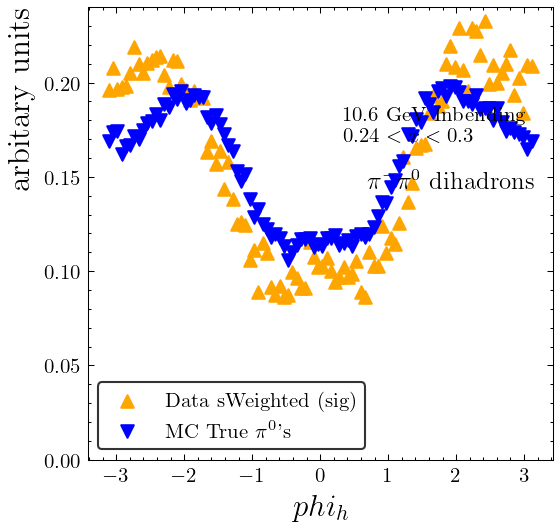

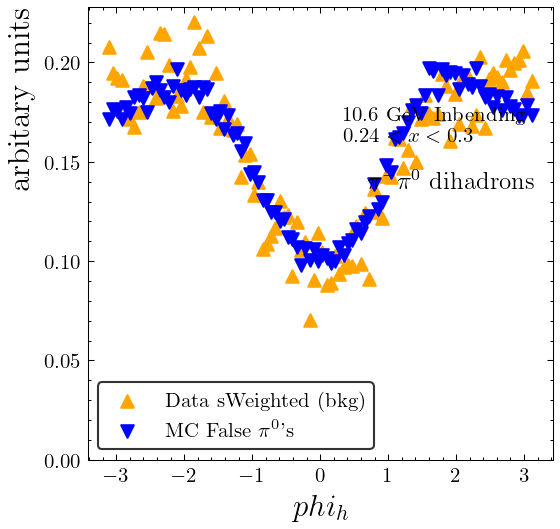

In [21]:
ML=True
which=-1 #1 = pi+, -1 = pi-
PROJECT_NAME="piminuspi0_prelim"
binname="x_0.235000_0.300000"
#binname="Mh_0.728571_0.871429"
#binname="z_0.700000_0.800000"
branchName="phi_h"
xlabel="phi_h"
N=10000000
tsweight,tdata,tmc = get_uproot_trees(PROJECT_NAME,"catboost","test1d","nSidis_Fall2018_inbending",binname,ML)
create_plot(tsweight,tdata,tmc,branchName,xlabel,N,binname,which,ML)

<ipython-input-12-8e5e2b617f8c>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(weights==[]):


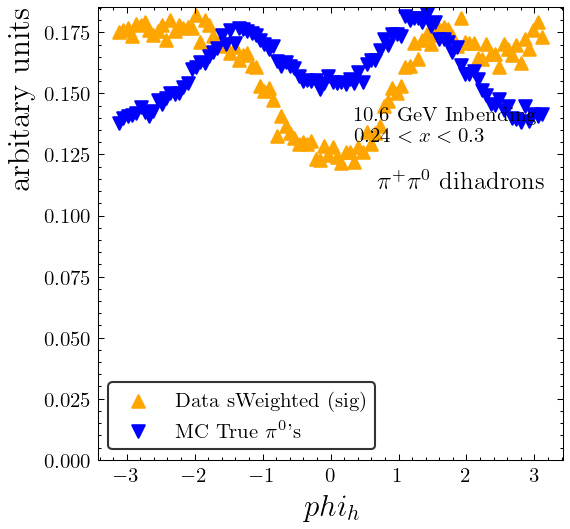

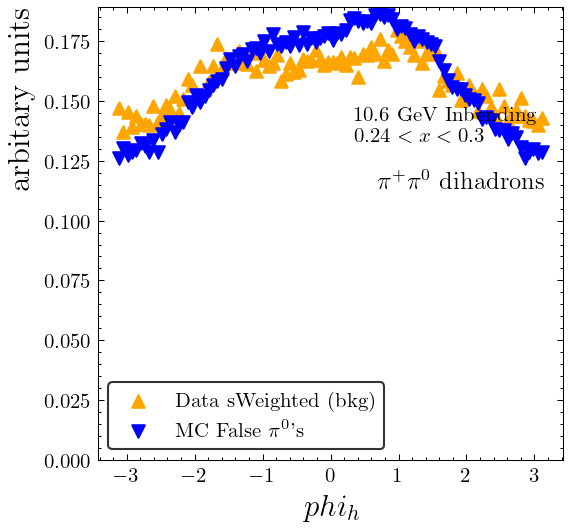

In [22]:
ML=True
which=1 #1 = pi+, -1 = pi-
PROJECT_NAME="pipluspi0_prelim"
binname="x_0.235000_0.300000"
#binname="Mh_0.728571_0.871429"
#binname="z_0.700000_0.800000"
branchName="phi_h"
xlabel="phi_h"
N=10000000
tsweight,tdata,tmc = get_uproot_trees(PROJECT_NAME,"catboost","test1d","nSidis_Fall2018_inbending",binname,ML)
create_plot(tsweight,tdata,tmc,branchName,xlabel,N,binname,which,ML)

<ipython-input-20-8e5e2b617f8c>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(weights==[]):


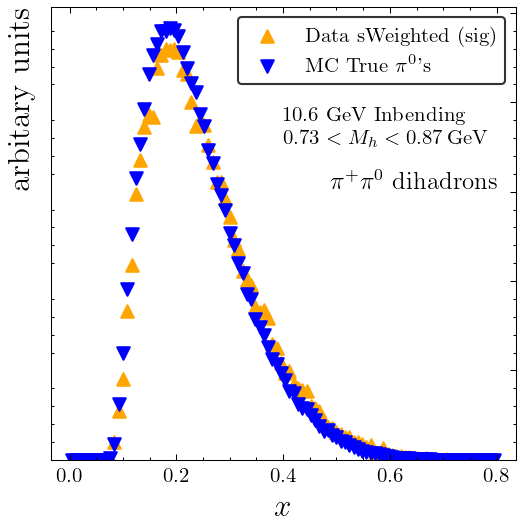

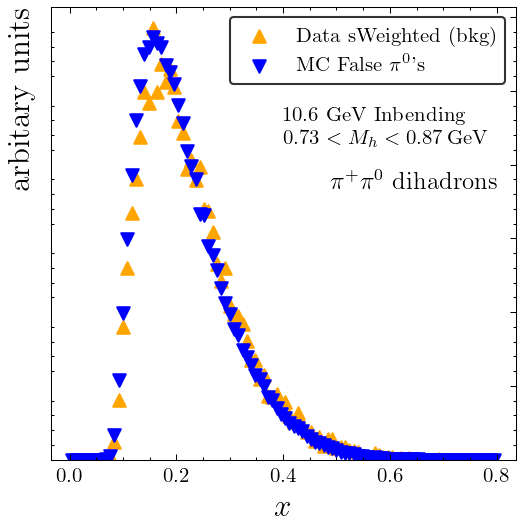

In [27]:
ML=True
which=1 #1 = pi+, -1 = pi-
PROJECT_NAME="piminuspi0_prelim"

binname="Mh_0.728571_0.871429"
branchName="x"
xlabel="x"
N=100000
tsweight,tdata,tmc = get_uproot_trees(PROJECT_NAME,"catboost","test1d","nSidis_Fall2018_inbending",binname,ML)
create_plot(tsweight,tdata,tmc,branchName,xlabel,N,binname,which,ML)

<ipython-input-38-8e5e2b617f8c>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(weights==[]):


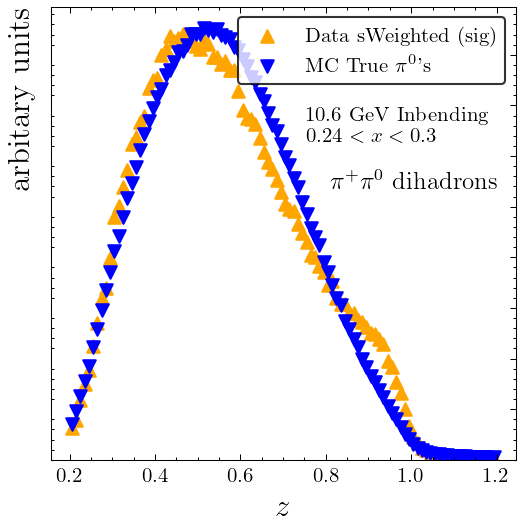

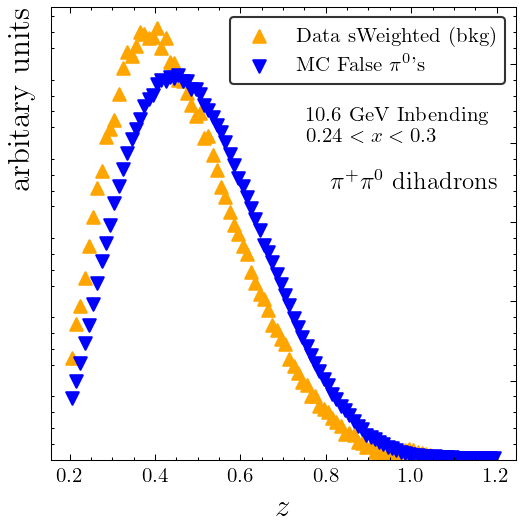

In [50]:
binname="x_0.235000_0.300000"
branchName="z"
xlabel="z"
tsweight,tdata,tmc = get_uproot_trees(PROJECT_NAME,"catboost","test1d","nSidis_Fall2018_inbending",binname,ML)
create_plot(tsweight,tdata,tmc,branchName,xlabel,N,binname,which,ML)

<ipython-input-38-8e5e2b617f8c>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(weights==[]):


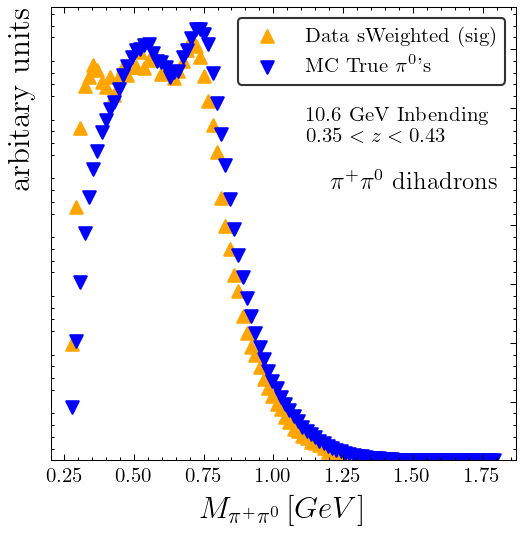

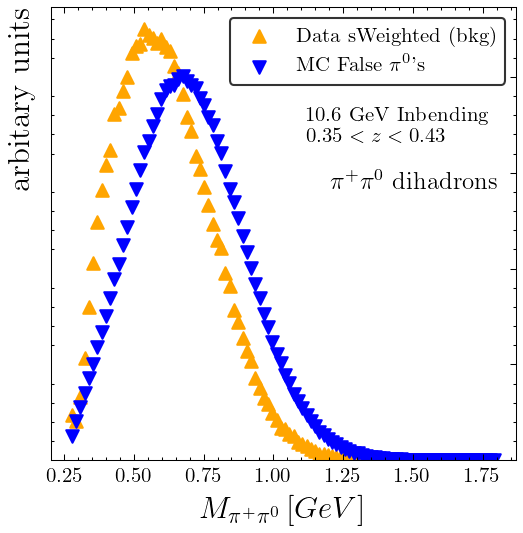

In [51]:
binname="z_0.350000_0.430000"
branchName="Mh"
xlabel="M_{\pi^+\pi^0}\,[GeV]"
tsweight,tdata,tmc = get_uproot_trees(PROJECT_NAME,"catboost","test1d","nSidis_Fall2018_inbending",binname,ML)
create_plot(tsweight,tdata,tmc,branchName,xlabel,N,binname,which,ML)

<ipython-input-137-8e5e2b617f8c>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(weights==[]):


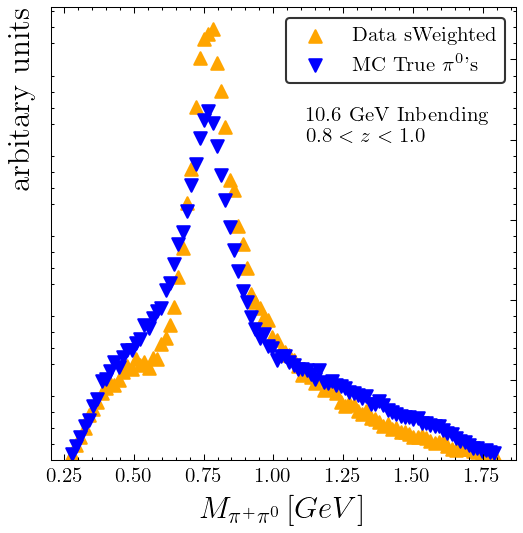

In [160]:
binname="z_0.800000_1.000000"
branchName="Mh"
N=1000000
xlabel="M_{\pi^+\pi^0}\,[GeV]"
tsweight,tdata,tmc = get_uproot_trees(PROJECT_NAME,"catboost","test1d","nSidis_Fall2018_inbending",binname,ML)
create_plot(tsweight,tdata,tmc,branchName,xlabel,N,binname,ML)

---

In [75]:
binname="Mh_0.728571_0.871429"
tsweight,tdata,tmc = get_uproot_trees("pipluspi0_prelim","catboost","test1d","nSidis_Fall2018_inbending",binname)

In [96]:
branchName="x"
data , mc    = get_signal_background(tsweight,tdata,tmc,branchName,100000)

<ipython-input-91-c74db75a3288>:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(weights==[]):


(0.0, 4.654247295248508)

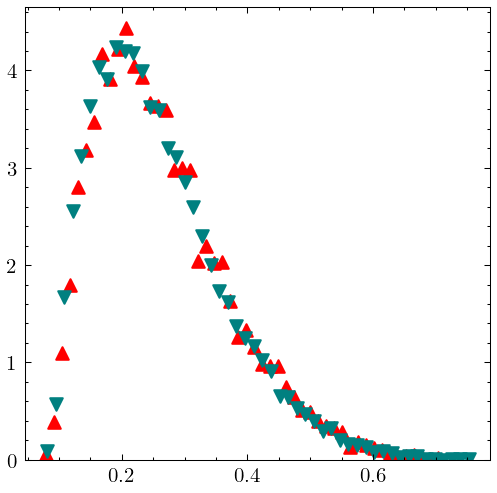

In [122]:
nbins=50

scatter_data_sig = get_plot_x_y(data[0],data[1][0])
scatter_data_bkg = get_plot_x_y(data[0],data[1][1])
scatter_mc_sig   = get_plot_x_y(mc[0])
scatter_mc_bkg   = get_plot_x_y(mc[1])


fig,axs = plt.subplots(1,1,dpi=150,figsize=(4,4))
axs.scatter(scatter_data_sig[0],scatter_data_sig[1],color="red",marker="^")
axs.scatter(scatter_mc_sig[0],scatter_mc_sig[1],color="teal",marker="v")
axs.set_ylim(0,axs.get_ylim()[1])

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


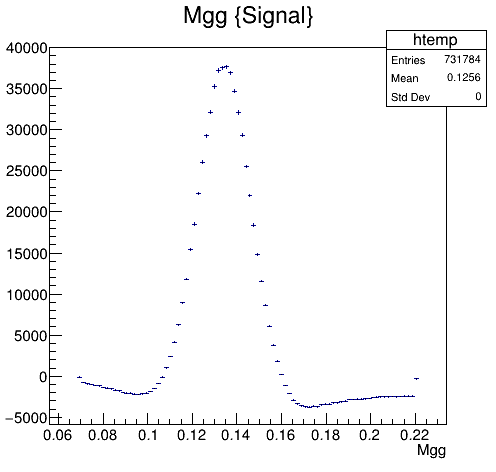

In [18]:
for iev in t:
    print(iev.x)
    break

0.0


---
# Data
---

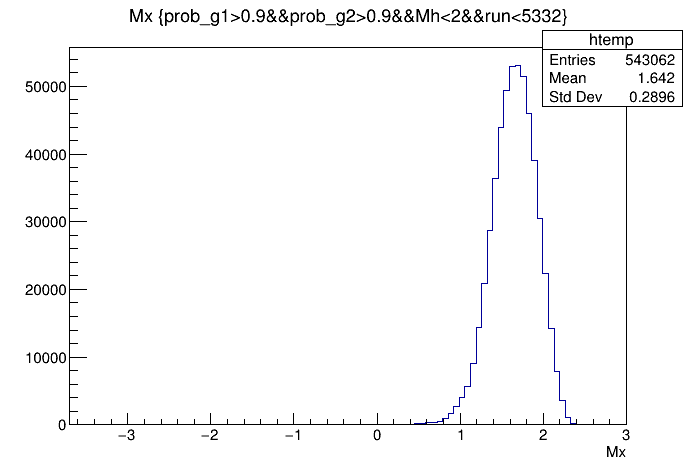

In [48]:
fdata=ROOT.TFile("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess_binned/test1d/nSidis_z_binned.root")
trees=[b.GetName() for b in fdata.GetListOfKeys()]
tdata=fdata.Get(trees[-5])
c=ROOT.TCanvas()
tdata.Draw("Mx","prob_g1>0.9&&prob_g2>0.9&&Mh<2&&run<5332")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h2_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2_mc (Potential memory leak).


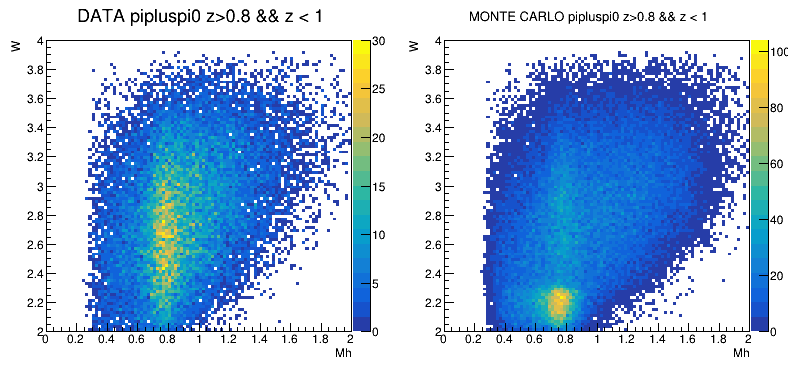

In [75]:
which=1
zcut="z>0.8 && z < 1"
if(which==1):
    text="pipluspi0"
else:
    text="piminuspi0"

c=ROOT.TCanvas("c","c",800,400)
c.Divide(2,1)
c.cd(1)
chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")

h2_data = ROOT.TH2F("h2_data",f"DATA {text} {zcut};Mh;W",100,0,2,100,2,4)
chain.Draw("W:Mh>>h2_data",f"xF>0&&prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}","colz")
ROOT.gStyle.SetOptStat(0)
c.SetLogz(0)

c.cd(2)
chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
h2_mc = ROOT.TH2F("h2_mc",f"MONTE CARLO {text} {zcut};Mh;W",100,0,2,100,2,4)
chain.Draw("W:Mh>>h2_mc",f"xF>0&&prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}","colz")

c.Draw()

In [ ]:
which=1
zcut="z>0.8 && z < 1"
if(which==1):
    text="pipluspi0"
else:
    text="piminuspi0"

c=ROOT.TCanvas("c","c",800,400)
c.Divide(2,1)
c.cd(1)
chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")

h2_data = ROOT.TH2F("h2_data",f"DATA {text};z;Mx",100,0,1.3,100,0,4)
chain.Draw("Mx:z>>h2_data",f"isGoodEventWithoutML&&Mh<2","colz")
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetLogz(0)

c.cd(2)
chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
h2_mc = ROOT.TH2F("h2_mc",f"MONTE CARLO {text};z;Mx",100,0,1.3,100,0,4)
chain.Draw("Mx:z>>h2_mc",f"isGoodEventWithoutML&&Mh<2","colz")
ROOT.gPad.SetLogz(0)

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h2_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2_mc (Potential memory leak).


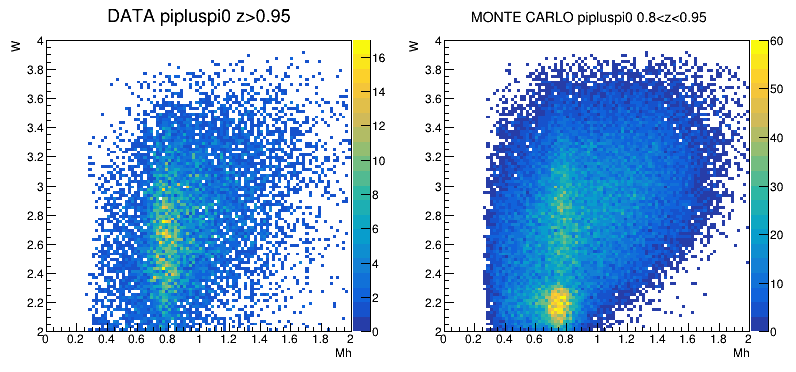

In [149]:
which=1
if(which==1):
    text="pipluspi0"
else:
    text="piminuspi0"

c=ROOT.TCanvas("c","c",800,400)
c.Divide(2,1)
c.cd(1)
chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")

h2_data = ROOT.TH2F("h2_data",f"DATA {text} z>0.95;Mh;W",100,0,2,100,2,4)
chain.Draw("W:Mh>>h2_data",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&z>0.9","colz")
ROOT.gStyle.SetOptStat(0)
c.SetLogz(0)

c.cd(2)
chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
h2_mc = ROOT.TH2F("h2_mc",f"MONTE CARLO {text} 0.8<z<0.95;Mh;W",100,0,2,100,2,4)
chain.Draw("W:Mh>>h2_mc",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&z>0.8&&z<0.9","colz")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h2_data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2_mc (Potential memory leak).


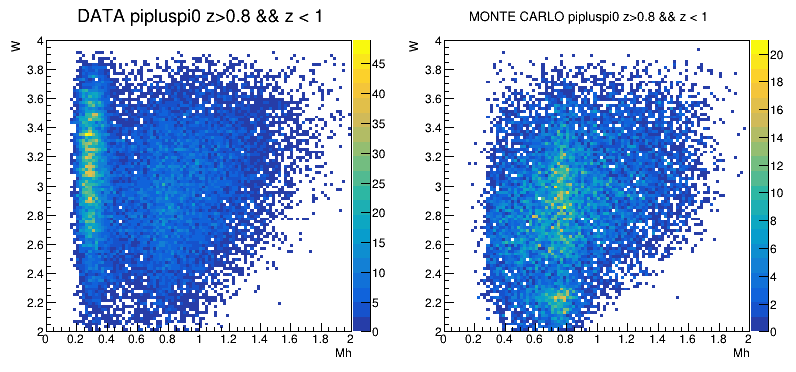

In [120]:
which=1
zcut="z>0.8 && z < 1"
if(which==1):
    text="pipluspi0"
else:
    text="piminuspi0"

c=ROOT.TCanvas("c","c",800,400)
c.Divide(2,1)
c.cd(1)
chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")

h2_data = ROOT.TH2F("h2_data",f"DATA {text} {zcut};Mh;W",100,0,2,100,2,4)
chain.Draw("W:Mh>>h2_data",f"xF>0&&isGoodEventWithoutML==1&&Mh<2&&{zcut}","colz")
ROOT.gStyle.SetOptStat(0)
c.SetLogz(0)

c.cd(2)
chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
h2_mc = ROOT.TH2F("h2_mc",f"MONTE CARLO {text} {zcut};Mh;W",100,0,2,100,2,4)
    chain.Draw("W:Mh>>h2_mc",f"truePi0==1&&xF>0&&isGoodEventWithoutML==1&&Mh<2&&{zcut}","colz")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


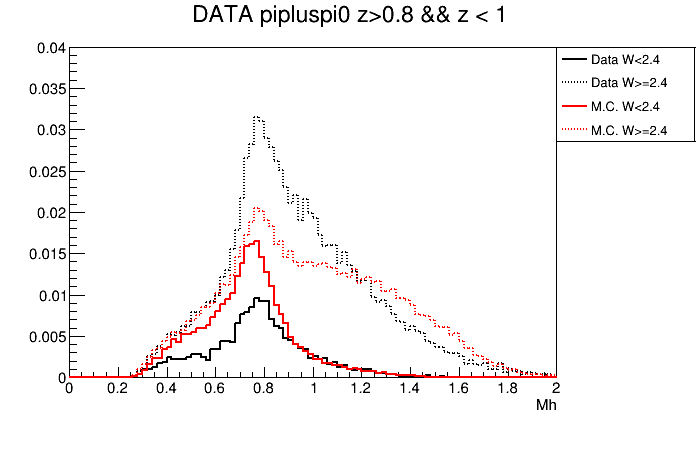

In [4]:
which=1
zcut="z>0.8 && z < 1"
if(which==1):
    text="pipluspi0"
else:
    text="piminuspi0"

branch="Mh"
xmin=0
xmax=2
ROOT.gStyle.SetHistLineWidth(2)
c=ROOT.TCanvas("c","c",700,500)
c.SetRightMargin(0.2)
c.SetBottomMargin(0.2)
chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")

h2_data_low = ROOT.TH1F("h2_data_low",f"DATA {text} {zcut};{branch};",100,xmin,xmax)
h2_data_high = ROOT.TH1F("h2_data_high",f"DATA {text} {zcut};{branch};",100,xmin,xmax)
chain.Draw(f"{branch}>>h2_data_low",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}&&W<2.4","hist")
chain.Draw(f"{branch}>>h2_data_high",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}&&W>=2.4","hist same")
ROOT.gStyle.SetOptStat(0)
c.SetLogz(0)
intData=h2_data_low.Integral()+h2_data_high.Integral()
h2_data_low.SetLineColor(1)
h2_data_low.Scale(1/intData)
h2_data_high.SetLineColor(1)
h2_data_high.Scale(1/intData)
h2_data_high.SetLineStyle(3)

chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
h2_mc_low = ROOT.TH1F("h2_mc_low",f"MONTE CARLO {text} {zcut};{branch};",100,xmin,xmax)
h2_mc_high = ROOT.TH1F("h2_mc_high",f"MONTE CARLO {text} {zcut};{branch};",100,xmin,xmax)
chain.Draw(f"{branch}>>h2_mc_low",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}&&W<2.4","hist same")
chain.Draw(f"{branch}>>h2_mc_high",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}&&W>=2.4","hist same")
intMC=h2_mc_low.Integral()+h2_mc_high.Integral()
h2_mc_low.Scale(1/intMC)
h2_mc_low.SetLineColor(2)
h2_mc_high.Scale(1/intMC)
h2_mc_high.SetLineColor(2)
h2_mc_high.SetLineStyle(3)

legend = ROOT.TLegend(0.8,0.7,1,0.9)
legend.AddEntry(h2_data_low ,"Data W<2.4","l")
legend.AddEntry(h2_data_high,"Data W>=2.4","l")
legend.AddEntry(h2_mc_low ,"M.C. W<2.4","l")
legend.AddEntry(h2_mc_high,"M.C. W>=2.4","l")
legend.Draw("same")

h2_data_low.GetYaxis().SetRangeUser(0,0.04)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h2_data_low (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2_data_high (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2_mc_low (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2_mc_high (Potential memory leak).


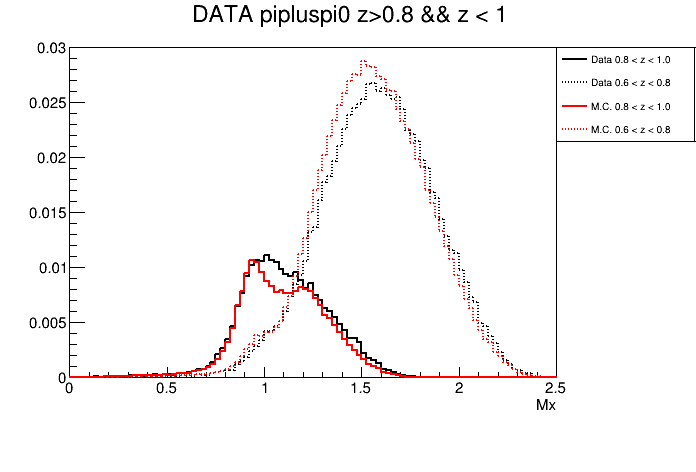

In [7]:
which=1
if(which==1):
    text="pipluspi0"
else:
    text="piminuspi0"

branch="Mx"
xmin=0
xmax=2.5
ROOT.gStyle.SetHistLineWidth(2)
c=ROOT.TCanvas("c","c",700,500)
c.SetRightMargin(0.2)
c.SetBottomMargin(0.2)
chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")

h2_data_low = ROOT.TH1F("h2_data_low",f"DATA {text} {zcut};{branch};",100,xmin,xmax)
h2_data_high = ROOT.TH1F("h2_data_high",f"DATA {text} {zcut};{branch};",100,xmin,xmax)
chain.Draw(f"{branch}>>h2_data_low",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&z>0.8&&z<1","hist")
chain.Draw(f"{branch}>>h2_data_high",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&z>0.6&&z<0.8","hist same")
ROOT.gStyle.SetOptStat(0)
c.SetLogz(0)
intData=h2_data_low.Integral()+h2_data_high.Integral()
h2_data_low.SetLineColor(1)
h2_data_low.Scale(1/intData)
h2_data_high.SetLineColor(1)
h2_data_high.Scale(1/intData)
h2_data_high.SetLineStyle(3)

chain = ROOT.TChain("dihadron")
chain.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
h2_mc_low = ROOT.TH1F("h2_mc_low",f"MONTE CARLO {text} {zcut};{branch};",100,xmin,xmax)
h2_mc_high = ROOT.TH1F("h2_mc_high",f"MONTE CARLO {text} {zcut};{branch};",100,xmin,xmax)
chain.Draw(f"{branch}>>h2_mc_low",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&z>0.8&&z<1","hist same")
chain.Draw(f"{branch}>>h2_mc_high",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&z>0.6&&z<0.8","hist same")
intMC=h2_mc_low.Integral()+h2_mc_high.Integral()
h2_mc_low.Scale(1/intMC)
h2_mc_low.SetLineColor(2)
h2_mc_high.Scale(1/intMC)
h2_mc_high.SetLineColor(2)
h2_mc_high.SetLineStyle(3)

legend = ROOT.TLegend(0.8,0.7,1,0.9)
legend.AddEntry(h2_data_low ,"Data 0.8 < z < 1.0","l")
legend.AddEntry(h2_data_high,"Data 0.6 < z < 0.8","l")
legend.AddEntry(h2_mc_low ,"M.C. 0.8 < z < 1.0","l")
legend.AddEntry(h2_mc_high,"M.C. 0.6 < z < 0.8","l")
legend.Draw("same")

h2_data_low.GetYaxis().SetRangeUser(0,0.03)
c.Draw()

Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).


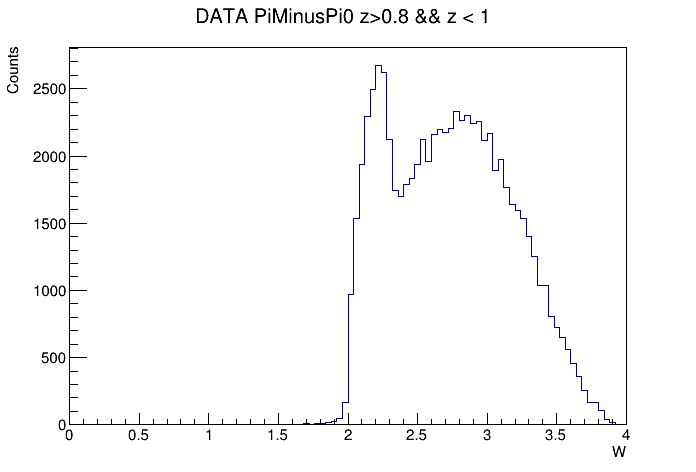

In [76]:
chain = ROOT.TChain("dihadron")
chain.Add("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess/nSidis_50*.root")
chain.Add("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess/MC_305*.root")
c=ROOT.TCanvas()

h2 = ROOT.TH1F("h2",f"DATA PiMinusPi0 {zcut};W;Counts",100,0,4)
chain.Draw("W>>h2",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}","colz")
ROOT.gStyle.SetOptStat(0)
c.SetLogz(1)
c.Draw()

Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h3 (Potential memory leak).


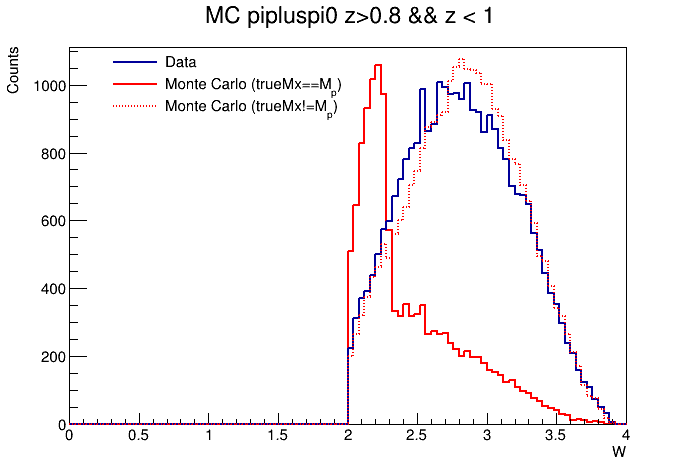

In [213]:
import ROOT
which=1
zcut="z>0.8 && z < 1"
if(which==1):
    text="pipluspi0"
else:
    text="piminuspi0"

chain1 = ROOT.TChain("dihadron")
chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")
h1 = ROOT.TH1F("h1",f"DATA {text} {zcut};W;Counts",100,0,4)
chain1.Draw("W>>h1",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}","goff")

chain2 = ROOT.TChain("dihadron")
chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
h2 = ROOT.TH1F("h2",f"MC {text} {zcut};W;Counts",100,0,4)
chain2.Draw("trueW>>h2",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}&&trueMx>0.938&&trueMx<0.940","goff")
h3 = ROOT.TH1F("h3",f"MC {text} {zcut};W;Counts",100,0,4)
chain2.Draw("trueW>>h3",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}&&(trueMx<0.938||trueMx>0.940)","goff")
h3.SetLineColor(2)
h3.SetLineStyle(3)
intMC=(h1.Integral()/h3.Integral())

h2.Scale(intMC)
h3.Scale(intMC)
h2.SetLineColor(2)
c=ROOT.TCanvas()
h2.Draw("hist")
h1.Draw("hist same")
h3.Draw("hist same")
legend = ROOT.TLegend(0.15,0.75,0.5,0.89)
legend.AddEntry(h1,"Data","l")
legend.AddEntry(h2,"Monte Carlo (trueMx==M_{p})","l")
legend.AddEntry(h3,"Monte Carlo (trueMx!=M_{p})","l")
legend.SetBorderSize(0)
legend.Draw("same")
c.Draw()

In [38]:
import ROOT
which=-1
zcut="z>0.75 && z < 0.9"
if(which==1):
    text="pipluspi0"
else:
    text="piminuspi0"

chain1 = ROOT.TChain("dihadron")
chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_param_test/catboost/postprocess/nSidis_50*.root")
h1 = ROOT.TH1F("h1",f"DATA {text} {zcut};W;arbitrary units",100,1.8,5)
chain1.Draw("W>>h1",f"prob_g1>0.9&&prob_g2>0.9&&Mh<2&&{zcut}","goff")

chain2 = ROOT.TChain("dihadron")
chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_param_test/catboost/postprocess/MC_305*.root")
h2 = ROOT.TH1F("h2",f"MC {text} {zcut};W;arbitrary units",100,1.8,5)
chain2.Draw("trueW>>h2",f"MCmatch==1&&Mh<2&&{zcut}&&trueMx>0.938&&trueMx<0.940","goff")
h3 = ROOT.TH1F("h3",f"MC {text} {zcut};W;arbitrary units",100,1.8,5)
chain2.Draw("trueW>>h3",f"MCmatch==1&&Mh<2&&{zcut}&&(trueMx<0.938||trueMx>0.940)","goff")
h3.SetLineColor(2)
h3.SetLineStyle(3)
intMC=(h1.Integral()/h3.Integral())

h2.Scale(intMC)
h3.Scale(intMC)
h2.SetLineColor(2)
c=ROOT.TCanvas("c","c",500,500)
h1.Draw("hist")
h2.Draw("hist same")
h3.Draw("hist same")
legend = ROOT.TLegend(0.5,0.75,0.88,0.88)
legend.AddEntry(h1,"Data","l")
legend.AddEntry(h2,"MC exclusive #rho^{+}","l")
legend.AddEntry(h3,"MC non-excl. #rho^{+}","l")
legend.SetBorderSize(0)
h1.GetYaxis().SetLabelSize(0)
legend.Draw("same")
c.Draw()

ZeroDivisionError: float division by zero

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


In [ ]:
import numpy as np
p_g1=[]
p_g2=[]
p_pi=[]
pp_g1=[]
pp_g2=[]
pp_pi=[]
pi_g1=[]
pi_g2=[]
pi_pi=[]
ppp_g1=[]
ppp_g2=[]
ppp_pi=[]
ppi_g1=[]
ppi_g2=[]
ppi_pi=[]
W=[]
z=[]
Mx=[]
trueMx=[]
for i,iev in enumerate(chain2):
    if(iev.prob_g1>0.9 and iev.prob_g2>0.9 and iev.Mh<2 and iev.z>0.8 and iev.z<1.0):
        p_g1.append(iev.truepid_gamma1)
        p_g2.append(iev.truepid_gamma2)
        p_pi.append(iev.truepid_pion)
        pp_g1.append(iev.trueparentpid_gamma1)
        pp_g2.append(iev.trueparentpid_gamma2)
        pp_pi.append(iev.trueparentpid_pion)
        pi_g1.append(iev.trueparentid_gamma1)
        pi_g2.append(iev.trueparentid_gamma2)
        pi_pi.append(iev.trueparentid_pion)
        ppp_g1.append(iev.trueparentparentpid_gamma1)
        ppp_g2.append(iev.trueparentparentpid_gamma2)
        ppp_pi.append(iev.trueparentparentpid_pion)
        ppi_g1.append(iev.trueparentparentid_gamma1)
        ppi_g2.append(iev.trueparentparentid_gamma2)
        ppi_pi.append(iev.trueparentparentid_pion)
        W.append(iev.W)
        z.append(iev.z)
        Mx.append(iev.Mx)
        trueMx.append(iev.trueMx)
    if(len(W)==5000):
        break
p_g1=np.array(p_g1)
p_g2=np.array(p_g2)
p_pi=np.array(p_pi)
pp_g1=np.array(pp_g1)
pp_g2=np.array(pp_g2)
pp_pi=np.array(pp_pi)
pi_g1=np.array(pi_g1)
pi_g2=np.array(pi_g2)
pi_pi=np.array(pi_pi)
ppp_g1=np.array(ppp_g1)
ppp_g2=np.array(ppp_g2)
ppp_pi=np.array(ppp_pi)
ppi_g1=np.array(ppi_g1)
ppi_g2=np.array(ppi_g2)
ppi_pi=np.array(ppi_pi)
W=np.array(W)
z=np.array(z)
Mx=np.array(Mx)
trueMx=np.array(trueMx)

In [39]:
import numpy as np
W0=[]
z0=[]
Mx0=[]
for i,iev in enumerate(chain1):
    if(iev.prob_g1>0.9 and iev.prob_g2>0.9 and iev.Mh<2 and iev.z>0.8 and iev.z<1):
        W0.append(iev.W)
        z0.append(iev.z)
        Mx0.append(iev.Mx)
    if(len(W0)==5000):
        break
W0=np.array(W0)
z0=np.array(z0)
Mx0=np.array(Mx0)

Text(0.5, 1.0, '$\\pi^+\\pi^0$ Monte Carlo Inbending Dihadrons')

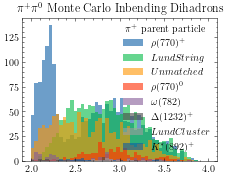

In [40]:
from particle import Particle
a,b=np.unique(pp_pi,return_counts=True)
idx=np.argsort(b)[::-1]
a=a[idx]
b=b[idx]
import matplotlib.pyplot as plt
for i in range(8):
    if(a[i]==92):
        LABEL="Lund String"
    elif(a[i]==91):
        LABEL="Lund Cluster"
    elif(a[i]==-999):
        LABEL="Unmatched"
    else:
        LABEL=f"{Particle.from_pdgid(a[i]).latex_name}"
    plt.hist(W[pp_pi==a[i]],label=r"${}$".format(LABEL),bins=50,range=(2,4),alpha=0.6)
plt.legend(title=r"$\pi^{+}$ parent particle")
plt.title(r"$\pi^+\pi^0$ Monte Carlo Inbending Dihadrons")

Text(0.5, 1.0, '$\\pi^+\\pi^0$ Monte Carlo Inbending Dihadrons')

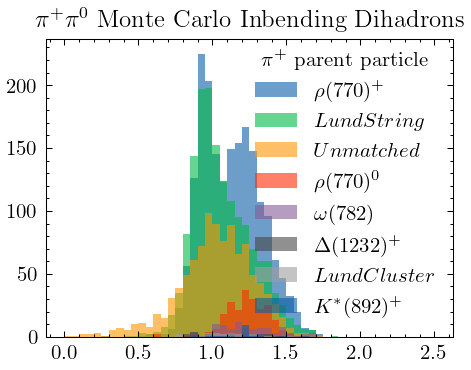

In [13]:
from particle import Particle
a,b=np.unique(pp_pi,return_counts=True)
idx=np.argsort(b)[::-1]
a=a[idx]
b=b[idx]
import matplotlib.pyplot as plt
plt.figure(dpi=150)
for i in range(8):
    if(a[i]==92):
        LABEL="Lund String"
    elif(a[i]==91):
        LABEL="Lund Cluster"
    elif(a[i]==-999):
        LABEL="Unmatched"
    else:
        LABEL=f"{Particle.from_pdgid(a[i]).latex_name}"
    plt.hist(Mx[pp_pi==a[i]],label=r"${}$".format(LABEL),bins=50,range=(0,2.5),alpha=0.6)
plt.legend(title=r"$\pi^{+}$ parent particle")
plt.title(r"$\pi^+\pi^0$ Monte Carlo Inbending Dihadrons")

Text(0.5, 1.0, '$\\pi^+\\pi^0$ Monte Carlo Inbending Dihadrons')

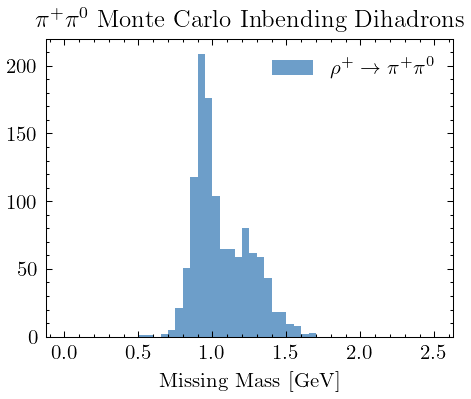

In [14]:
from particle import Particle
a,b=np.unique(pp_pi,return_counts=True)
idx=np.argsort(b)[::-1]
a=a[idx]
b=b[idx]
import matplotlib.pyplot as plt
plt.figure(dpi=150)
cut = ((pp_pi==213) & (ppp_g1==213) & (ppp_g2==213) & (pi_pi==ppi_g1) & (pi_pi==ppi_g2) & (ppi_g1!=-999))
plt.hist(Mx[cut],bins=50,range=(0,2.5),alpha=0.6,label=r"$\rho^+\rightarrow\pi^+\pi^0$")
plt.legend()
plt.xlabel("Missing Mass [GeV]")
plt.title(r"$\pi^+\pi^0$ Monte Carlo Inbending Dihadrons")

Text(0.5, 1.0, '$\\pi^+\\pi^0$ Monte Carlo Inbending Dihadrons')

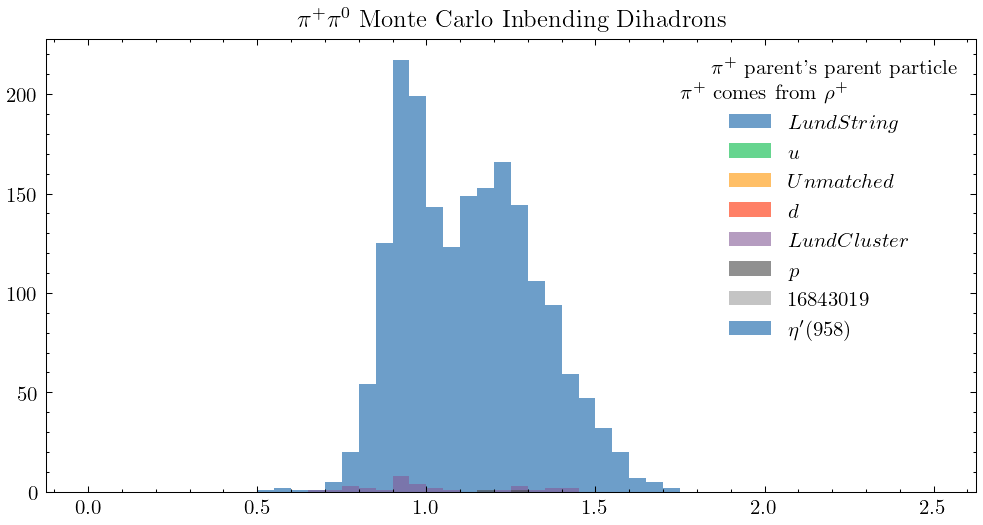

In [15]:
from particle import Particle
a,b=np.unique(ppp_pi,return_counts=True)
idx=np.argsort(b)[::-1]
a=a[idx]
b=b[idx]
import matplotlib.pyplot as plt
plt.figure(dpi=150,figsize=(8,4))
for i in range(8):
    if(a[i]==92):
        LABEL="Lund String"
    elif(a[i]==91):
        LABEL="Lund Cluster"
    elif(a[i]==-999):
        LABEL="Unmatched"
    elif(a[i]==16843019):
        LABEL=16843019
    else:
        LABEL=f"{Particle.from_pdgid(a[i]).latex_name}"
    plt.hist(Mx[(ppp_pi==a[i]) & (pp_pi==213)],label=r"${}$".format(LABEL),bins=50,range=(0,2.5),alpha=0.6)
plt.legend(title=r" $\pi^{+}$ parent's parent particle \\ $\pi^+$ comes from $\rho^+$")
plt.title(r"$\pi^+\pi^0$ Monte Carlo Inbending Dihadrons")

Text(0.5, 1.0, '$\\pi^+\\pi^0$ Monte Carlo Inbending Dihadrons')

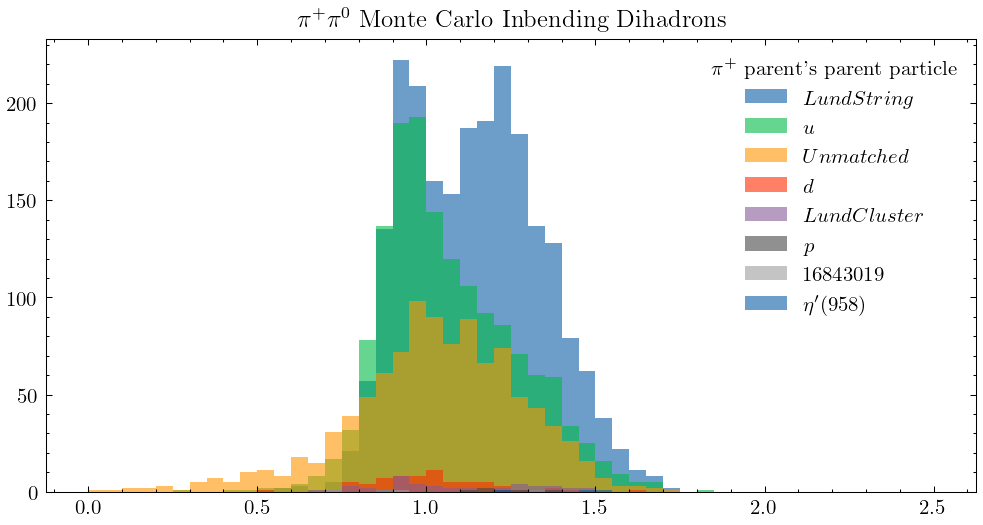

In [16]:
from particle import Particle
a,b=np.unique(ppp_pi,return_counts=True)
idx=np.argsort(b)[::-1]
a=a[idx]
b=b[idx]
import matplotlib.pyplot as plt
plt.figure(dpi=150,figsize=(8,4))
for i in range(8):
    if(a[i]==92):
        LABEL="Lund String"
    elif(a[i]==91):
        LABEL="Lund Cluster"
    elif(a[i]==-999):
        LABEL="Unmatched"
    elif(a[i]==16843019):
        LABEL=16843019
    else:
        LABEL=f"{Particle.from_pdgid(a[i]).latex_name}"
    plt.hist(Mx[ppp_pi==a[i]],label=r"${}$".format(LABEL),bins=50,range=(0,2.5),alpha=0.6)
plt.legend(title=r"$\pi^{+}$ parent's parent particle")
plt.title(r"$\pi^+\pi^0$ Monte Carlo Inbending Dihadrons")

Text(0.5, 1.0, '$\\pi^+\\pi^0$ Monte Carlo Inbending Dihadrons')

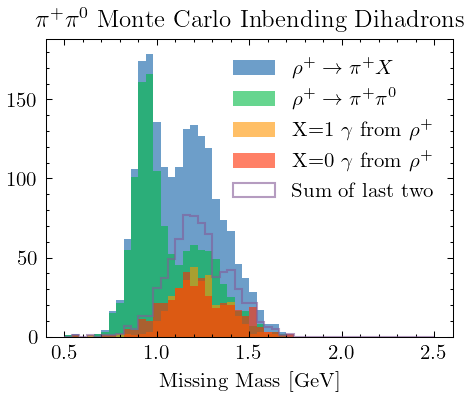

In [20]:
from particle import Particle
a,b=np.unique(pp_pi,return_counts=True)
idx=np.argsort(b)[::-1]
a=a[idx]
b=b[idx]
import matplotlib.pyplot as plt
plt.figure(dpi=150)

# PiPlus comes from a Rho Decay
cutA = ((pp_pi==213))
# PiPlusPi0 comes from the same Rho Decay
cutB = ((pp_pi==213) & (ppp_g1==213) & (ppp_g2==213))
# PiPlusPi0 where the PiPlus comes from a Rho and the Pi0 does not
cutC = ((pp_pi==213) & ((ppp_g1!=213) & (ppp_g2!=213)))
# PiPlusPi0 where the PiPlus come from a Rho and only one photon comes from a pi0 from a rho
cutD = ((pp_pi==213) & ((ppp_g1==213) ^ (ppp_g2==213)))
plt.hist(Mx[cutA],bins=50,range=(0.5,2.5),alpha=0.6,label=r"$\rho^+\rightarrow\pi^+X$")
plt.hist(Mx[cutB],bins=50,range=(0.5,2.5),alpha=0.6,label=r"$\rho^+\rightarrow\pi^+\pi^0$")
plt.hist(Mx[cutC],bins=50,range=(0.5,2.5),alpha=0.6,label=r"X=1 $\gamma$ from $\rho^+$")
plt.hist(Mx[cutD],bins=50,range=(0.5,2.5),alpha=0.6,label=r"X=0 $\gamma$ from $\rho^+$")
plt.hist(np.concatenate([Mx[cutC],Mx[cutD]]),bins=50,range=(0.5,2.5),histtype="step",alpha=0.6,label=r"Sum of last two")
plt.legend()
plt.xlabel("Missing Mass [GeV]")
plt.title(r"$\pi^+\pi^0$ Monte Carlo Inbending Dihadrons")

Text(0.5, 1.0, '$\\pi^+\\pi^0$ Monte Carlo Inbending Dihadrons')

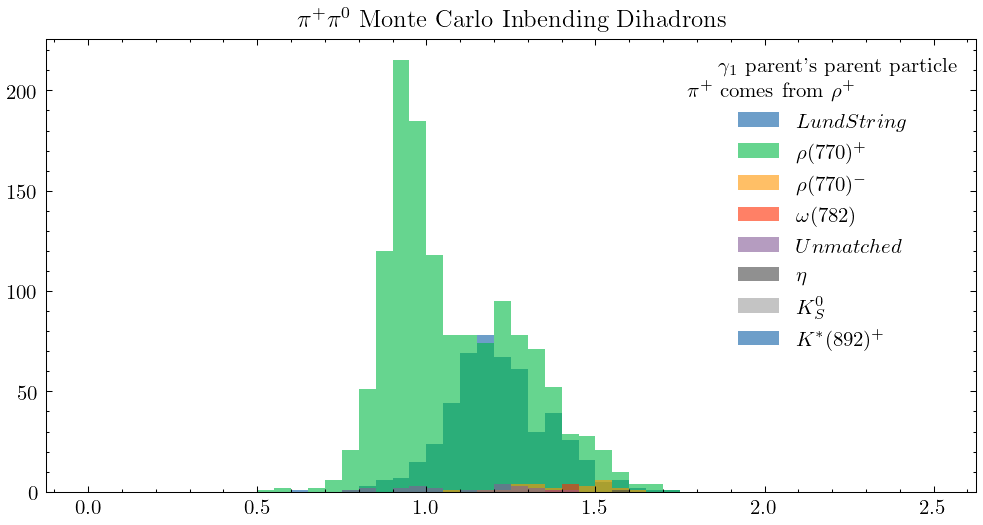

In [18]:
from particle import Particle
a,b=np.unique(ppp_g1,return_counts=True)
idx=np.argsort(b)[::-1]
a=a[idx]
b=b[idx]
import matplotlib.pyplot as plt
plt.figure(dpi=150,figsize=(8,4))
for i in range(8):
    if(a[i]==92):
        LABEL="Lund String"
    elif(a[i]==91):
        LABEL="Lund Cluster"
    elif(a[i]==-999):
        LABEL="Unmatched"
    elif(a[i]==16843019):
        LABEL=16843019
    else:
        LABEL=f"{Particle.from_pdgid(a[i]).latex_name}"
    plt.hist(Mx[(ppp_g1==a[i]) & (pp_pi==213)],label=r"${}$".format(LABEL),bins=50,range=(0,2.5),alpha=0.6)
plt.legend(title=r" $\gamma_{1}$ parent's parent particle \\ $\pi^+$ comes from $\rho^+$")
plt.title(r"$\pi^+\pi^0$ Monte Carlo Inbending Dihadrons")

Text(0.5, 1.0, '$\\pi^+\\pi^0$ Monte Carlo Inbending Dihadrons')

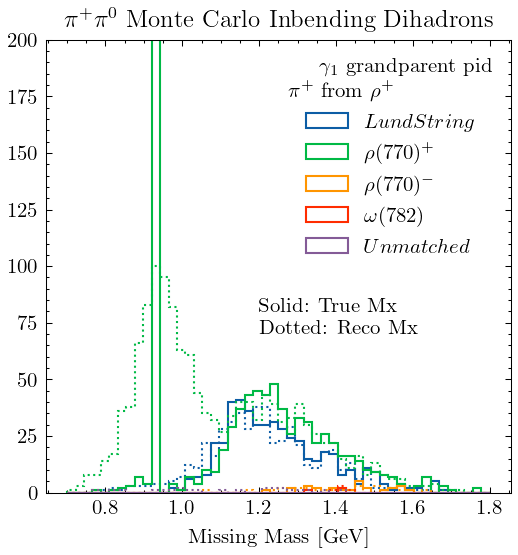

In [37]:
from particle import Particle
a,b=np.unique(ppp_g1,return_counts=True)
idx=np.argsort(b)[::-1]
a=a[idx]
b=b[idx]
import matplotlib.pyplot as plt
plt.figure(dpi=150,figsize=(4,4))
for i in range(5):
    if(a[i]==92):
        LABEL="Lund String"
    elif(a[i]==91):
        LABEL="Lund Cluster"
    elif(a[i]==-999):
        LABEL="Unmatched"
    elif(a[i]==16843019):
        LABEL=16843019
    else:
        LABEL=f"{Particle.from_pdgid(a[i]).latex_name}"
    plt.hist(trueMx[(ppp_g1==a[i]) & (pp_pi==213)],label=r"${}$".format(LABEL),bins=50,range=(0.7,1.8),histtype="step",color="C" + str(i))
    plt.hist(Mx[(ppp_g1==a[i]) & (pp_pi==213)],bins=50,range=(0.7,1.8),histtype="step",linestyle="dotted",color="C" + str(i))
#plt.hist(Mx,bins=50,range=(0,2.5),color="black",histtype="step",linestyle="dotted",label="All Monte Carlo")
#plt.hist(Mx0,bins=50,range=(0,2.5),color="black",histtype="step",weights=np.ones_like(Mx0),label="All nSidis Data")
plt.legend(title=r" $\gamma_{1}$ grandparent pid \\ $\pi^+$ from $\rho^+$")
plt.ylim(0,200)
plt.text(1.2,80,"Solid: True Mx")
plt.text(1.2,70,"Dotted: Reco Mx")
plt.xlabel("Missing Mass [GeV]")
plt.title(r"$\pi^+\pi^0$ Monte Carlo Inbending Dihadrons")

# PHI_H IS WEIRD
---

In [143]:
import ROOT
which=1
if(which==1):
    text="pipluspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
else:
    text="piminuspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_54*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_331*.root")


h1=ROOT.TH1F("h1","PiPlusPi0 Dihadrons w/ CatBoost p>0.9;#phi_{h};",100,-3.14,3.14); h1.SetLineColor(1); h1.SetLineWidth(2);
h2=ROOT.TH1F("h2","",100,-3.14,3.14); h2.SetLineColor(2); h2.SetLineWidth(2);
h3=ROOT.TH1F("h3","",100,-3.14,3.14); h3.SetLineColor(4); h3.SetLineWidth(2);
c=ROOT.TCanvas("c","c",600,600)
chain1.Draw("phi_h>>h1","prob_g1>0.9&&prob_g2>0.9","E1 hist")
chain2.Draw("phi_h>>h2","prob_g1>0.9&&prob_g2>0.9&&(truepid_pion==211)","E1 hist same")
chain2.Draw("phi_h>>h3","prob_g1>0.9&&prob_g2>0.9&&(truepid_pion!=211)","E1 hist same")

h1.Scale(h2.Integral()/h1.Integral())
h3.Scale(h2.Integral()/h3.Integral())
legend=ROOT.TLegend(0.5,0.15,0.75,0.3)
legend.AddEntry(h1,"Data","l")
legend.AddEntry(h2,"MC (pid==211)","l")
legend.AddEntry(h3,"MC (pid!=211)","l")
legend.Draw("same")
h1.GetYaxis().SetRangeUser(5000,11500)
c.Draw()

ZeroDivisionError: float division by zero

Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h3 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h3 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


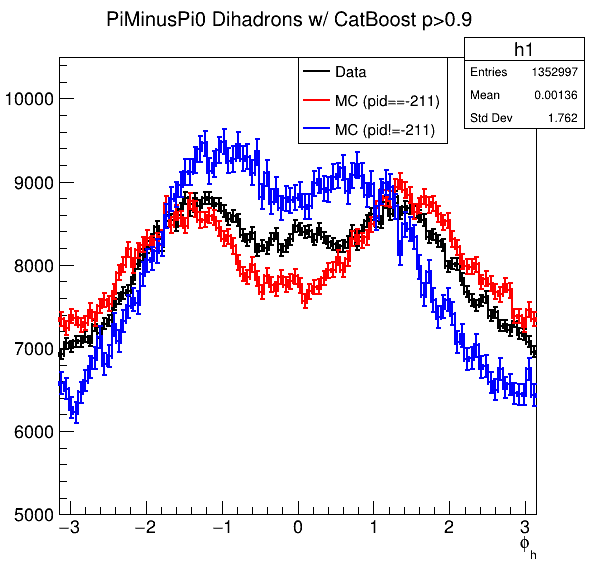

In [133]:
import ROOT
which=-1
if(which==1):
    text="pipluspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
else:
    text="piminuspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_54*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_331*.root")


h1=ROOT.TH1F("h1","PiMinusPi0 Dihadrons w/ CatBoost p>0.9;#phi_{h};",100,-3.14,3.14); h1.SetLineColor(1); h1.SetLineWidth(2);
h2=ROOT.TH1F("h2","",100,-3.14,3.14); h2.SetLineColor(2); h2.SetLineWidth(2);
h3=ROOT.TH1F("h3","",100,-3.14,3.14); h3.SetLineColor(4); h3.SetLineWidth(2);
c=ROOT.TCanvas("c","c",600,600)
chain1.Draw("phi_h>>h1","prob_g1>0.9&&prob_g2>0.9","E1 hist")
chain2.Draw("phi_h>>h2","prob_g1>0.9&&prob_g2>0.9&&(truepid_pion==-211)","E1 hist same")
chain2.Draw("phi_h>>h3","prob_g1>0.9&&prob_g2>0.9&&(truepid_pion!=-211)","E1 hist same")

h1.Scale(h2.Integral()/h1.Integral())
h3.Scale(h2.Integral()/h3.Integral())
legend=ROOT.TLegend(0.5,0.75,0.75,0.9)
legend.AddEntry(h1,"Data","l")
legend.AddEntry(h2,"MC (pid==-211)","l")
legend.AddEntry(h3,"MC (pid!=-211)","l")
legend.Draw("same")
h1.GetYaxis().SetRangeUser(5000,10500)
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


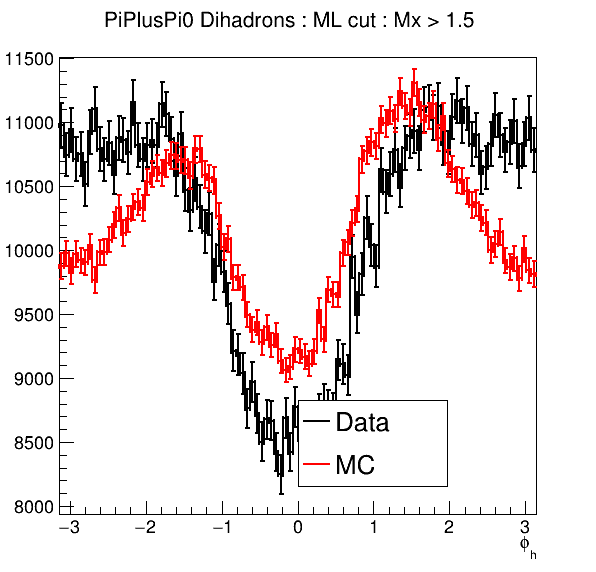

In [26]:
import ROOT
which=1
if(which==1):
    text="pipluspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
else:
    text="piminuspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_54*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_331*.root")


h1=ROOT.TH1F("h1","PiPlusPi0 Dihadrons : ML cut : Mx > 1.5;#phi_{h};",100,-3.14,3.14); h1.SetLineColor(1); h1.SetLineWidth(2);
h2=ROOT.TH1F("h2","",100,-3.14,3.14); h2.SetLineColor(2); h2.SetLineWidth(2);
#h3=ROOT.TH1F("h3","",100,-3.14,3.14); h3.SetLineColor(4); h3.SetLineWidth(2);
c=ROOT.TCanvas("c","c",600,600)
#chain1.Draw("phi_h>>h1","prob_g1>0.9&&prob_g2>0.9","E1 hist")
#chain2.Draw("phi_h>>h2","prob_g1>0.9&&prob_g2>0.9","E1 hist same")
#chain1.Draw("phi_h>>h1","isGoodEventWithoutML","E1 hist")
#chain2.Draw("phi_h>>h2","isGoodEventWithoutML","E1 hist same")
chain1.Draw("phi_h>>h1","prob_g1>0.9&&prob_g2>0.9&&Mx>1.5","E1 hist")
chain2.Draw("phi_h>>h2","prob_g1>0.9&&prob_g2>0.9&&Mx>1.5","E1 hist same")
h1.Scale(h2.Integral()/h1.Integral())
#h3.Scale(h2.Integral()/h3.Integral())
legend=ROOT.TLegend(0.5,0.15,0.75,0.3)
legend.AddEntry(h1,"Data","l")
legend.AddEntry(h2,"MC","l")
legend.Draw("same")
#h1.GetYaxis().SetRangeUser(5000,20000)
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


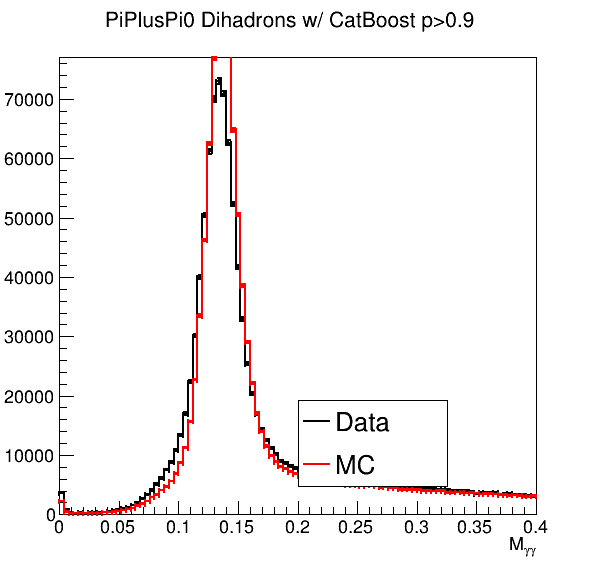

In [15]:
import ROOT
which=1
if(which==1):
    text="pipluspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
else:
    text="piminuspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_54*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_331*.root")


h1=ROOT.TH1F("h1","PiPlusPi0 Dihadrons w/ CatBoost p>0.9;M_{#gamma#gamma};",100,0,0.4); h1.SetLineColor(1); h1.SetLineWidth(2);
h2=ROOT.TH1F("h2","",100,0,0.4); h2.SetLineColor(2); h2.SetLineWidth(2);
#h3=ROOT.TH1F("h3","",100,-3.14,3.14); h3.SetLineColor(4); h3.SetLineWidth(2);
c=ROOT.TCanvas("c","c",600,600)
#chain1.Draw("phi_h>>h1","prob_g1>0.9&&prob_g2>0.9","E1 hist")
#chain2.Draw("phi_h>>h2","prob_g1>0.9&&prob_g2>0.9","E1 hist same")
#chain1.Draw("phi_h>>h1","isGoodEventWithoutML","E1 hist")
#chain2.Draw("phi_h>>h2","isGoodEventWithoutML","E1 hist same")
chain1.Draw("Mgg>>h1","prob_g1>0.9&&prob_g2>0.9","E1 hist")
chain2.Draw("Mgg>>h2","prob_g1>0.9&&prob_g2>0.9","E1 hist same")
h1.Scale(h2.Integral()/h1.Integral())
#h3.Scale(h2.Integral()/h3.Integral())
legend=ROOT.TLegend(0.5,0.15,0.75,0.3)
legend.AddEntry(h1,"Data","l")
legend.AddEntry(h2,"MC","l")
legend.Draw("same")
#h1.GetYaxis().SetRangeUser(5000,20000)
c.Draw()

In [ ]:
import ROOT
which=1
if(which==1):
    text="pipluspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")
    #chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_54*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
    #chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_331*.root")
else:
    text="piminuspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_54*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_331*.root")


h1=ROOT.TH1F("h1","PiPlusPi0 Dihadrons;#phi_{h};",100,-3.14,3.14); h1.SetLineColor(1); h1.SetLineWidth(2);
h2=ROOT.TH1F("h2","",100,-3.14,3.14); h2.SetLineColor(2); h2.SetLineWidth(2);
#h3=ROOT.TH1F("h3","",100,-3.14,3.14); h3.SetLineColor(4); h3.SetLineWidth(2);
c=ROOT.TCanvas("c","c",600,600)
chain1.Draw("phi_h>>h1","g1E>0.6&&g2E>0.6","E1 hist")
chain2.Draw("phi_h>>h2","g1E>0.6&&g2E>0.6","E1 hist same")
h1.Scale(h2.Integral()/h1.Integral())
#h3.Scale(h2.Integral()/h3.Integral())
legend=ROOT.TLegend(0.5,0.15,0.75,0.3)
legend.AddEntry(h1,"Data","l")
legend.AddEntry(h2,"MC","l")
legend.Draw("same")
#h1.GetYaxis().SetRangeUser(5000,20000)
c.Draw()

Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


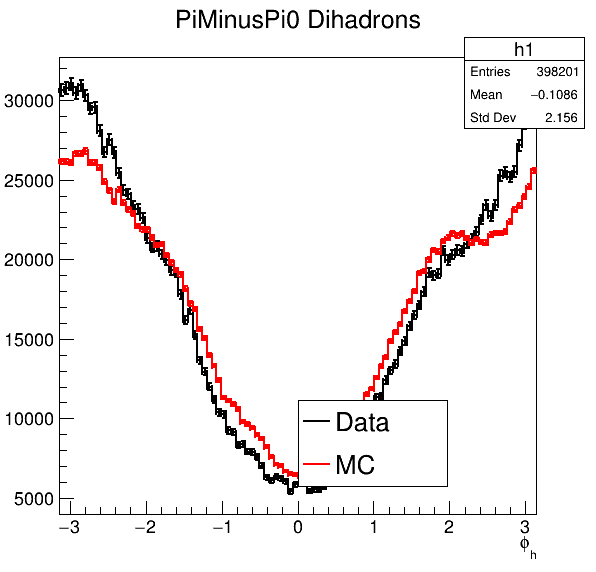

In [176]:
import ROOT
which=-1
if(which==1):
    text="pipluspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
else:
    text="piminuspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")
    #chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_54*.root")
    chain2 = ROOT.TChain("dihadron")
    #chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_331*.root")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")

h1=ROOT.TH1F("h1","PiMinusPi0 Dihadrons;#phi_{h};",100,-3.14,3.14); h1.SetLineColor(1); h1.SetLineWidth(2);
h2=ROOT.TH1F("h2","",100,-3.14,3.14); h2.SetLineColor(2); h2.SetLineWidth(2);
#h3=ROOT.TH1F("h3","",100,-3.14,3.14); h3.SetLineColor(4); h3.SetLineWidth(2);
c=ROOT.TCanvas("c","c",600,600)
# chain1.Draw("phi_h>>h1","prob_g1>0.9&&prob_g2>0.9","E1 hist")
# chain2.Draw("phi_h>>h2","prob_g1>0.9&&prob_g2>0.9","E1 hist same")
chain1.Draw("phi_h>>h1","","E1 hist")
chain2.Draw("phi_h>>h2","","E1 hist same")
h1.Scale(h2.Integral()/h1.Integral())
#h3.Scale(h2.Integral()/h3.Integral())
legend=ROOT.TLegend(0.5,0.15,0.75,0.3)
legend.AddEntry(h1,"Data","l")
legend.AddEntry(h2,"MC","l")
legend.Draw("same")
#h1.GetYaxis().SetRangeUser(5000,20000)
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


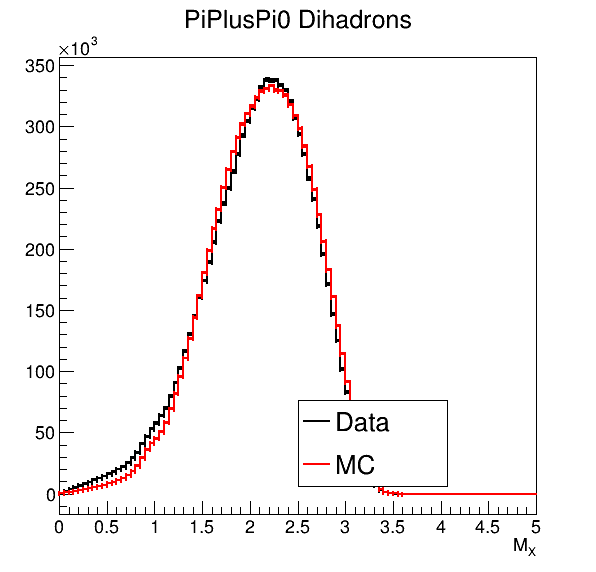

In [18]:
import ROOT
which=1
if(which==1):
    text="pipluspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")
    chain2 = ROOT.TChain("dihadron")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")
else:
    text="piminuspi0"
    chain1 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_50*.root")
    #chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/nSidis_54*.root")
    chain2 = ROOT.TChain("dihadron")
    #chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_331*.root")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/MC_305*.root")

h1=ROOT.TH1F("h1","PiPlusPi0 Dihadrons;M_{X};",100,0,5); h1.SetLineColor(1); h1.SetLineWidth(2);
h2=ROOT.TH1F("h2","",100,0,5); h2.SetLineColor(2); h2.SetLineWidth(2);
#h3=ROOT.TH1F("h3","",100,-3.14,3.14); h3.SetLineColor(4); h3.SetLineWidth(2);
c=ROOT.TCanvas("c","c",600,600)
# chain1.Draw("phi_h>>h1","prob_g1>0.9&&prob_g2>0.9","E1 hist")
# chain2.Draw("phi_h>>h2","prob_g1>0.9&&prob_g2>0.9","E1 hist same")
chain1.Draw("Mx>>h1","","E1 hist")
chain2.Draw("Mx>>h2","","E1 hist same")
h1.Scale(h2.Integral()/h1.Integral())
#h3.Scale(h2.Integral()/h3.Integral())
legend=ROOT.TLegend(0.5,0.15,0.75,0.3)
legend.AddEntry(h1,"Data","l")
legend.AddEntry(h2,"MC","l")
legend.Draw("same")
#h1.GetYaxis().SetRangeUser(5000,20000)
c.Draw()

In [140]:
import uproot
u = uproot.open("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/piminuspi0_prelim/catboost/postprocess/MC_3051_0.root:dihadron")
pids=u["truepid_pion"].array(library="np")

In [141]:
19564/(19564+94659)

0.17127898934540328

In [142]:
print(np.unique(pids,return_counts=True))

(array([-999, -321, -211,   11,   13,   22,  130,  211, 2112, 2212],
      dtype=int32), array([19564,    54, 94659,    36,     5,    61,     6,    32,     4,
           5]))


In [119]:
import uproot
u = uproot.open("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/pipluspi0_prelim/catboost/postprocess/MC_3051_0.root:dihadron")
pids=u["truepid_pion"].array(library="np")

In [138]:
155184/(155184+475516)

0.24605042016806722

In [120]:
print(np.unique(pids,return_counts=True))

(array([-999, -321, -211,  -13,  -11,   11,   22,  130,  211,  321, 2112,
       2212], dtype=int32), array([155184,      2,    106,     14,    374,     63,    604,      7,
       475516,   1554,     70,   1630]))


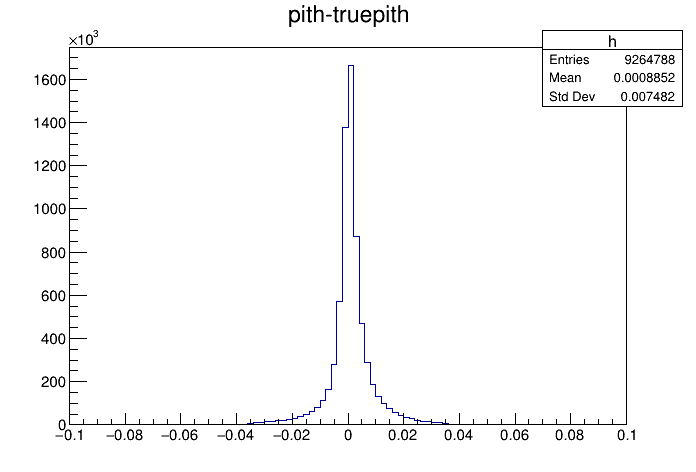

In [158]:
c=ROOT.TCanvas()
chain2.Draw("pith-truepith>>h(100,-.1,.1)","")
c.Draw()

# Phi_h grids

In [2]:
import ROOT
import numpy as np
def get_tchains(bending,pion):
    if(bending=="in"):
        mctext="MC_305*.root"
        datatext="nSidis_50*.root"
    else:
        mctext="MC_331*.root"
        datatext="nSidis_54*.root"
    if(pion==1):
        text="pipluspi0"
    else:
        text="piminuspi0"
    chain1 = ROOT.TChain("dihadron")
    chain2 = ROOT.TChain("dihadron")
    chain1.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/{datatext}")
    chain2.Add(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects/{text}_prelim/catboost/postprocess/{mctext}")
    return chain1,chain2

def get_th1fs(bending,pion,varname,xmin,xmax):
    if(bending=="in"):
        header1="Inbending"
    else:
        header1="Outbending"
    if(pion==1):
        header2="#pi^{+}#pi^{0}"
    else:
        header2="#pi^{-}#pi^{0}"
    h1=ROOT.TH1F(f"h1{np.random.uniform()}",f"{header2} Dihadrons, {header1} Monte Carlo ;{varname};",40,xmin,xmax); h1.SetLineColor(1); h1.SetLineWidth(2);
    h2=ROOT.TH1F(f"h2{np.random.uniform()}","",40,xmin,xmax); h2.SetLineColor(2); h2.SetLineWidth(2);
    return h1,h2

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


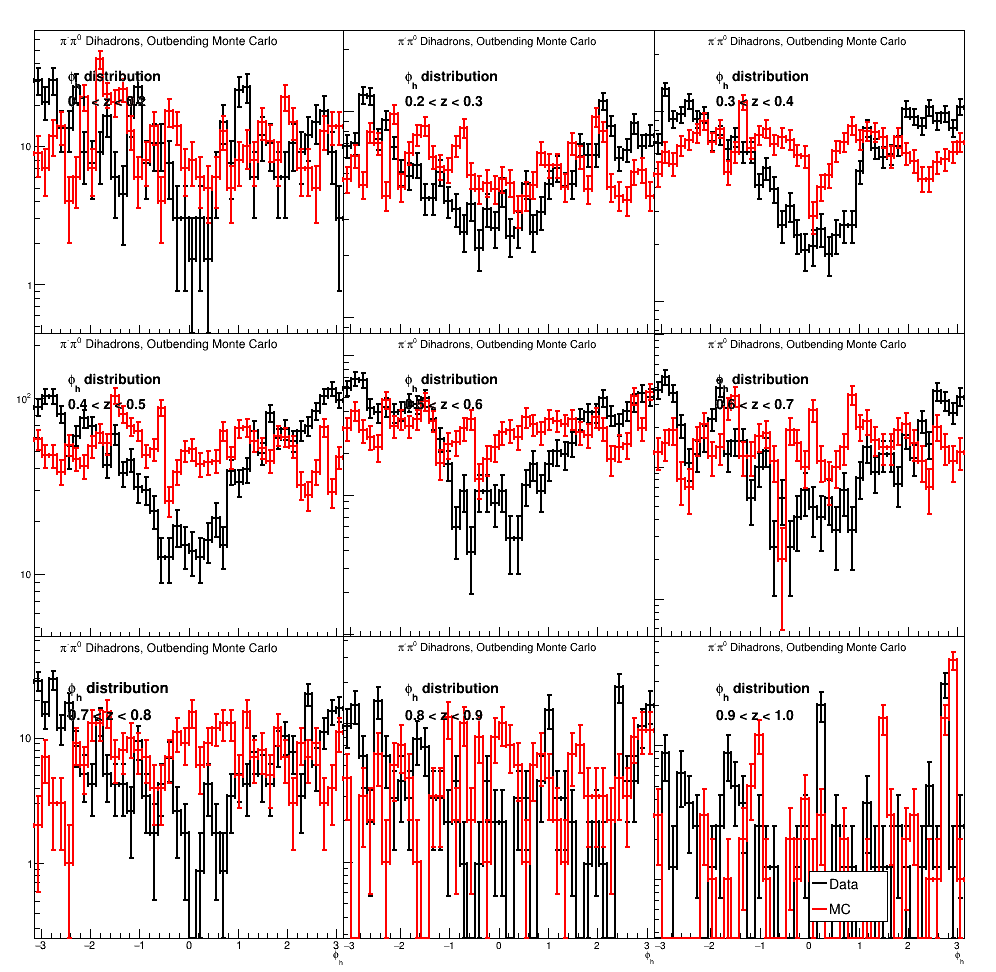

In [222]:
pion=-1
bending="out"
varname="#phi_{h}"
var="phi_h"

chain1, chain2 = get_tchains(bending,pion)
c=ROOT.TCanvas("c","c",1000,1000)
c.Divide(3,3,0,0)
z_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] #List of z bins 

H1=[]
H2=[]
for i in range(9):
    c.cd(i+1)
    ROOT.gStyle.SetOptStat(0)
    h1,h2=get_th1fs(bending,pion,varname,-3.14,3.14)
    H1.append(h1)
    H2.append(h2)
    ROOT.gPad.SetLogy()
    chain1.Draw(f"{var}>>{h1.GetName()}",f"z > {z_bins[i]} && z < {z_bins[i+1]}","E1 hist",10000)
    chain2.Draw(f"{var}>>{h2.GetName()}",f"z > {z_bins[i]} && z < {z_bins[i+1]}","E1 hist same",10000)
    if(h1.Integral()==0):
        continue
    h1.Scale(h2.Integral()/h1.Integral())
    legend=ROOT.TLegend(0.5,0.15,0.75,0.3)
    legend.AddEntry(h1,"Data","l")
    legend.AddEntry(h2,"MC","l")
    legend.Draw("same")
    latex=ROOT.TLatex()
    latex.DrawLatexNDC(.2,.83,f"{varname} distribution")
    latex.DrawLatexNDC(.2,.75,f"{z_bins[i]} < z < {z_bins[i+1]}")
    
c.Draw()

# z of charged pion

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


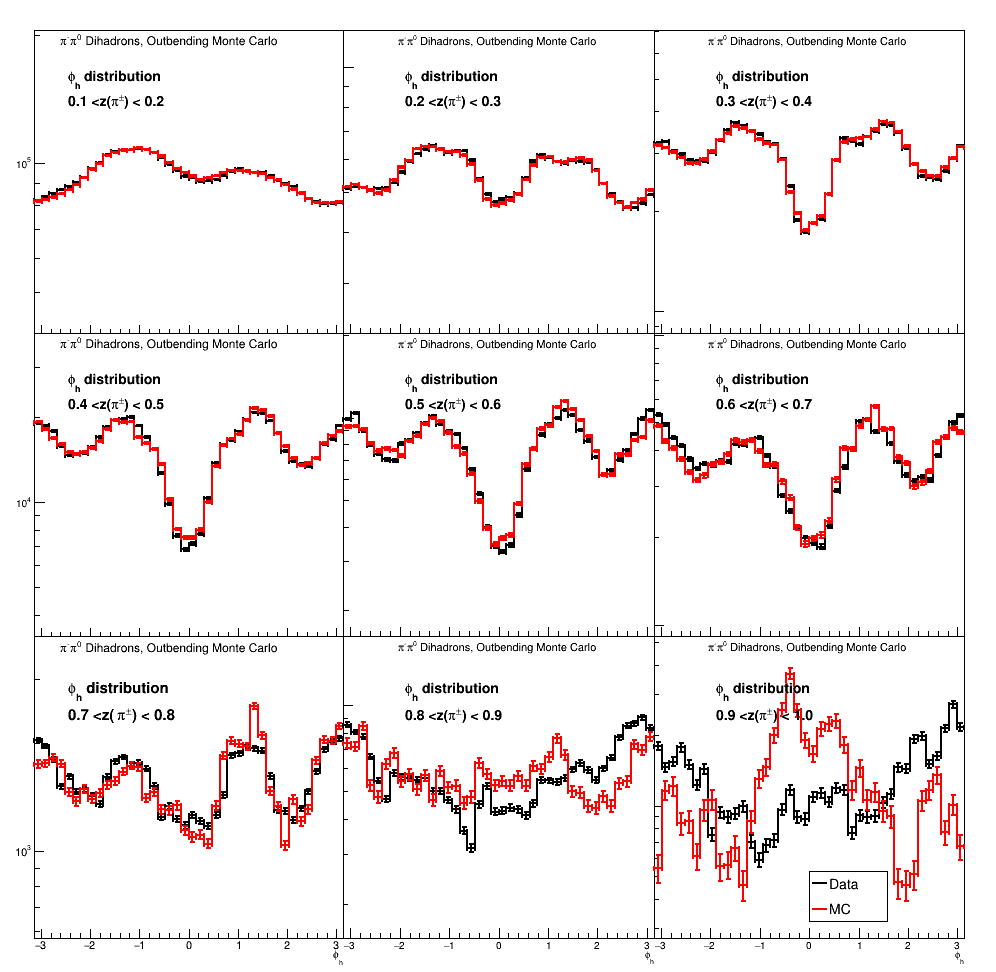

In [227]:
pion=-1
bending="out"
varname="#phi_{h}"
var="phi_h"

chain1, chain2 = get_tchains(bending,pion)
c=ROOT.TCanvas("c","c",1000,1000)
c.Divide(3,3,0,0)
z_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] #List of z bins 

H1=[]
H2=[]
for i in range(9):
    c.cd(i+1)
    ROOT.gStyle.SetOptStat(0)
    h1,h2=get_th1fs(bending,pion,varname,-3.14,3.14)
    H1.append(h1)
    H2.append(h2)
    ROOT.gPad.SetLogy()
    chain1.Draw(f"{var}>>{h1.GetName()}",f"zpiplus > {z_bins[i]} && zpiplus < {z_bins[i+1]}","E1 hist")
    chain2.Draw(f"{var}>>{h2.GetName()}",f"zpiplus > {z_bins[i]} && zpiplus < {z_bins[i+1]}","E1 hist same")
    if(h1.Integral()==0):
        continue
    h1.Scale(h2.Integral()/h1.Integral())
    legend=ROOT.TLegend(0.5,0.15,0.75,0.3)
    legend.AddEntry(h1,"Data","l")
    legend.AddEntry(h2,"MC","l")
    legend.Draw("same")
    latex=ROOT.TLatex()
    latex.DrawLatexNDC(.2,.83,f"{varname} distribution")
    latex.DrawLatexNDC(.2,.75,f"{z_bins[i]} <"+"z(#pi^{#pm})"+f" < {z_bins[i+1]}")
    
c.Draw()

# z of neutral pion

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


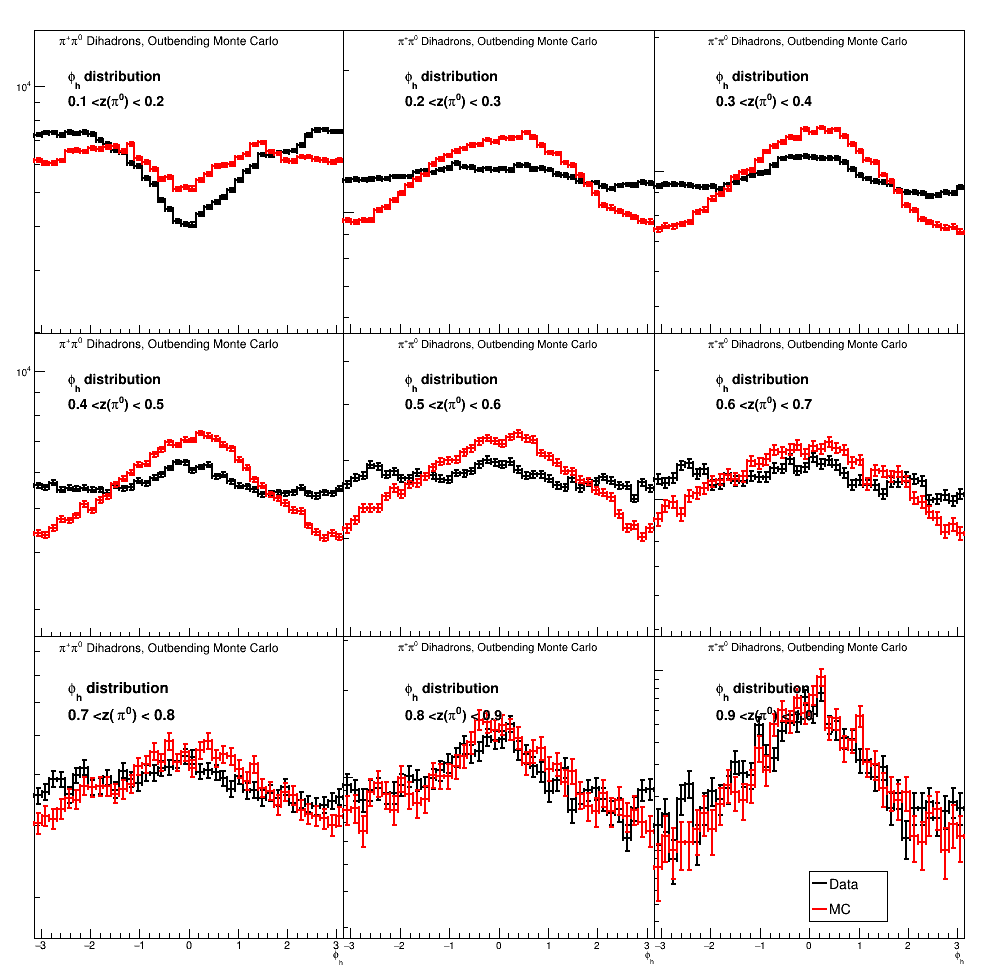

In [232]:
pion=1
bending="out"
varname="#phi_{h}"
var="phi_h"

chain1, chain2 = get_tchains(bending,pion)
c=ROOT.TCanvas("c","c",1000,1000)
c.Divide(3,3,0,0)
z_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] #List of z bins 

H1=[]
H2=[]
for i in range(9):
    c.cd(i+1)
    ROOT.gStyle.SetOptStat(0)
    h1,h2=get_th1fs(bending,pion,varname,-3.14,3.14)
    H1.append(h1)
    H2.append(h2)
    ROOT.gPad.SetLogy()
    chain1.Draw(f"{var}>>{h1.GetName()}",f"zpi0 > {z_bins[i]} && zpi0 < {z_bins[i+1]}","E1 hist")
    chain2.Draw(f"{var}>>{h2.GetName()}",f"zpi0 > {z_bins[i]} && zpi0 < {z_bins[i+1]}","E1 hist same")
    if(h1.Integral()==0):
        continue
    h1.Scale(h2.Integral()/h1.Integral())
    legend=ROOT.TLegend(0.5,0.15,0.75,0.3)
    legend.AddEntry(h1,"Data","l")
    legend.AddEntry(h2,"MC","l")
    legend.Draw("same")
    latex=ROOT.TLatex()
    latex.DrawLatexNDC(.2,.83,f"{varname} distribution")
    latex.DrawLatexNDC(.2,.75,f"{z_bins[i]} <"+"z(#pi^{0})"+f" < {z_bins[i+1]}")
    
c.Draw()

# Multidimensional

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file plots/inbending_1_0.0_0.2.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file plots/inbending_1_0.2_0.4.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file plots/inbending_1_0.4_0.6.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file plots/inbending_1_0.6_0.8.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file plots/inbending_1_0.8_1.0.png has been created


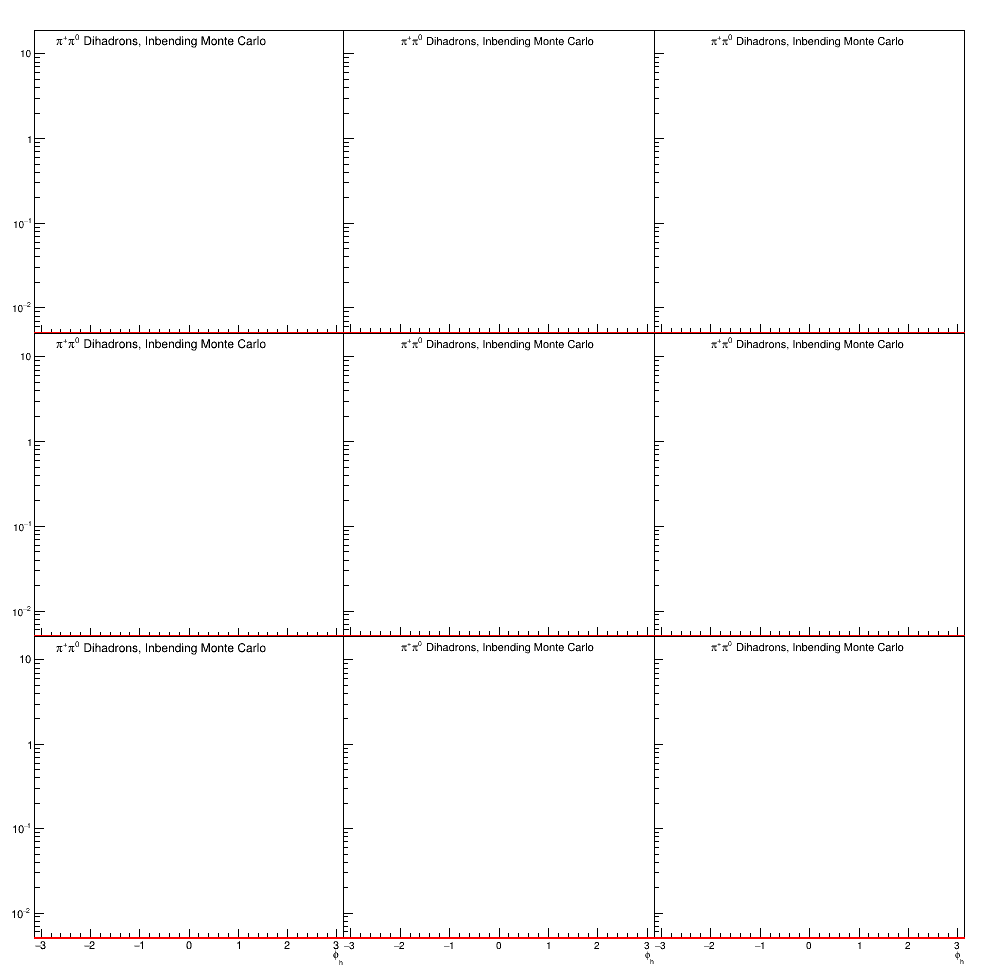

In [20]:
pion=1
bending="in"
varname="#phi_{h}"
var="phi_h"

chain1, chain2 = get_tchains(bending,pion)

z_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] #List of z bins 

for z2_bins in [[0.0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1.0]]:
    c=ROOT.TCanvas("c","c",1000,1000)
    c.Divide(3,3,0,0)
    H1=[]
    H2=[]
    for i in range(9):
        c.cd(i+1)
        ROOT.gStyle.SetOptStat(0)
        h1,h2=get_th1fs(bending,pion,varname,-3.14,3.14)
        H1.append(h1)
        H2.append(h2)
        ROOT.gPad.SetLogy()
        chain1.Draw(f"{var}>>{h1.GetName()}",f"zpiplus > {z_bins[i]} && zpiplus < {z_bins[i+1]} && zpi0>{z2_bins[0]} && zpi0<{z2_bins[1]} && prob_g1>0.9 && prob_g2>0.9 && Mx > 1.5","E1 hist")
        chain2.Draw(f"{var}>>{h2.GetName()}",f"zpiplus > {z_bins[i]} && zpiplus < {z_bins[i+1]} && zpi0>{z2_bins[0]} && zpi0<{z2_bins[1]} && prob_g1>0.9 && prob_g2>0.9 && Mx > 1.5","E1 hist same")
        if(h1.Integral()==0):
            continue
        h1.Scale(h2.Integral()/h1.Integral())
        legend=ROOT.TLegend(0.5,0.15,0.75,0.3)
        legend.AddEntry(h1,"Data","l")
        legend.AddEntry(h2,"MC","l")
        legend.Draw("same")
        latex=ROOT.TLatex()
        latex.DrawLatexNDC(.2,.87,f"{varname} distribution w/ ML cuts")
        latex.DrawLatexNDC(.75,.87,"M_{X}>1.5")
        latex.DrawLatexNDC(.2,.79,f"{z_bins[i]} <"+"z(#pi^{#pm})"+f" < {z_bins[i+1]}")
        latex.DrawLatexNDC(.6,.79,f"{z2_bins[0]} <"+"z(#pi^{0})"+f" < {z2_bins[1]}")

    c.Draw()
    c.SaveAs(f"plots/{bending}bending_{pion}_{z2_bins[0]}_{z2_bins[1]}.png")